In [1]:
from __future__ import division

import os
import numpy as np
import time, timeit
import signal
import scipy.io as scio
from scipy import stats
from scipy.sparse import coo_matrix
from MDPD import *
from MDPD.readers import *
from MDPD import utils
import matplotlib.pyplot as plt
import matplotlib

----
## Read Data

In [2]:
# folder = '/media/vzhao/Data/crowdsourcing_datasets/'
folder = '/Users/vincent/Documents/Research/MDPD/crowdsourcing_datasets'

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'bird', 'bluebird_crowd.txt'), os.path.join(folder, 'bird', 'bluebird_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:], dtype=np.bool)
print train.shape

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'dog', 'dog_crowd.txt'), os.path.join(folder, 'dog', 'dog_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'rte', 'rte_crowd.txt'), os.path.join(folder, 'rte', 'rte_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

In [ ]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'trec', 'trec_crowd.txt'), os.path.join(folder, 'trec', 'trec_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

In [3]:
reader = Crowd_Sourcing_Readers(os.path.join(folder, 'web', 'web_crowd.txt'), os.path.join(folder, 'web', 'web_truth.txt'))
train, label = reader.data, reader.labels
lock = np.zeros(train.shape[1:],dtype=np.bool)
lock[:, -1] = 1
print train.shape

2018-04-05 00:28:11,979 : INFO : Data has missing values. A new label is created to represent the missing values.


(2653, 177, 6)


#### Update global variables

In [4]:
NSAMPLE, DIM, NVOCAB = train.shape
EFF_NVOCAB = NVOCAB-1 if reader.is_missing_value else NVOCAB

---
## Analysis

## Original Mutual Information Residue

In [5]:
%%time
# Original mutual information residue (G score)
score_origin = utils.Feature_Selection.MI_score(train, rm_diag=True, lock=lock)
sigma_origin = score_origin.sum(axis=1)
print np.sum(score_origin) / (DIM * (DIM-1))

0.0536595099464
CPU times: user 515 ms, sys: 103 ms, total: 617 ms
Wall time: 383 ms


MDPD/utils.py:211: RuntimeWarning: divide by zero encountered in log
  log_second_scaled = np.log(second_masked)


#### Reference G Statistics

In [6]:
percentages = [99,95,90,75,50]
percentiles = [stats.chi2.ppf(x/100., (EFF_NVOCAB**2 - 1)) / (2 * NSAMPLE) for x in percentages]
print 'Reference G statistis at {} percentile'.format(percentages)
print percentiles

Reference G statistis at [99, 95, 90, 75, 50] percentile
[0.0081002299546459912, 0.006862990671279174, 0.0062563596473102483, 0.0053224934085052316, 0.0043981768386900733]


## Mutual Information Residue if use the true label as the posterior distribution

In [7]:
# label to log_post
def label2logpost(label, ncomp):
    nsample = label.shape[0]
    post = np.zeros((nsample, ncomp))
    for i in xrange(nsample):
        post[i, label[i]] = 1
    return np.log(post)
log_post = label2logpost(label,label.max()+1)
utils.log_replace_neginf(log_post)

/Users/vincent/.virtualenvs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [9]:
%%time
score, weights = MDPD.utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True, lock=lock)
score_condition = score.sum(axis=1)
print 'Mutual Information Residue if use the true label as the posterior distribution'
print np.sum(score_condition * weights[np.newaxis, :]) / (DIM * (DIM - 1))

Mutual Information Residue if use the true label as the posterior distribution
0.0148103717514
CPU times: user 4.73 s, sys: 526 ms, total: 5.26 s
Wall time: 3.16 s


#### [Plot] Mutual Information Residue if use the true label as the posterior distribution vs. Raw Residue

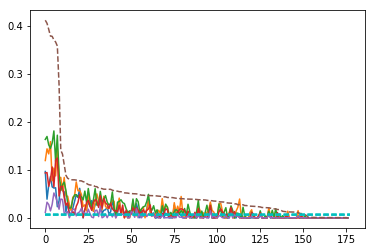

In [13]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in xrange(train.shape[2]-1 if np.any(lock) else train.shape[2]):
    plt.plot(score_condition[idx,k]/(DIM - 1))
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

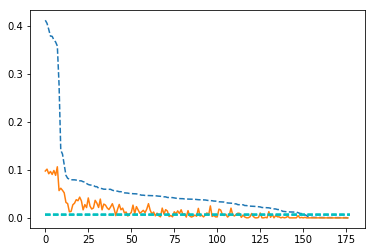

In [14]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
plt.plot(np.sum(score_condition[idx,:] * weights[np.newaxis, :], axis=1) / (DIM - 1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

## Mixture Model with Feature Selection Performance

#### Feature Ranking

In [15]:
%%time
features, sigma = utils.Feature_Selection.MI_feature_ranking(train, lock=lock)
print features

[  2   7   0  11  12   6   1  15  25  13  10   3  44  32 102   5  69  38
  29  36   8  62 106  58 103  56  46  27  24  23  52  51  28  41  21  31
  74  68  33  35  77  99  75  64 114  50  82  17 142 109 117  65 107 100
  30 129  93  19  26 105  40  86  98  90  59  37  91 112  78  34  81  67
 120 126   4  70 134  61   9  83  47  18 130  71  49 135 124  96 127  92
 119  72  88 104  48 108  55  85 144  14 118  16  39  87 101  60 139  89
  54 155 140 132  63  84  94 113 138 145  95 158  22  42 116 165  80  57
  45  66 164 143  53 147  76 125 161 123 128 153 141 121  79  20  97 131
 111 160 122  43 157  73 115 133 110 156 148 150 137 173 146 162 168 159
 167 176 169 175 163 136 171 172 166 151 154 170 149 174 152]
CPU times: user 500 ms, sys: 120 ms, total: 620 ms
Wall time: 382 ms


#### Accuracy and Mutual Information Residue

In [16]:
Ntop = 15

In [17]:
# Feature Selection
model = MDPD.MDPD()
model.fit(train, ncomp=5, init='majority', verbose=False, features=features[:Ntop], epoch=50, lock=lock)
model.accuracy(train, label)
model.MI_residue(train)

2018-04-05 00:29:46,638 : INFO : Training an MDPD with dimension 177, 15 features, sample size 2653, vocab size 6 and the target number of components 5
MDPD/utils.py:92: RuntimeWarning: divide by zero encountered in log
  log_votes = np.log(votes)
MDPD/MDPD.py:234: RuntimeWarning: divide by zero encountered in log
  log_margin_prob = np.log(data.sum(axis=0) / data.shape[0])
2018-04-05 00:30:14,485 : INFO : ACCURACY: 89.82%
2018-04-05 00:30:17,613 : INFO : The mutual information residue (include all features) is 0.0254033680676
2018-04-05 00:30:17,615 : INFO : The mutual information residue (within selected features) is 0.117649493487


In [ ]:
# optional
model.change_features(train, features=range(model.dim))
model.accuracy(train, label)

#### [Plot] Mutual Information Residue vs the Residue of the Raw Data

In [18]:
log_post = model.log_posterior(train)
score, weights = MDPD.utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True, lock=lock)
score_condition = score.sum(axis=1)
print 'Mutual Information Residue of the model with feature selection'
print np.sum(score_condition * weights[np.newaxis, :]) / (DIM * (DIM - 1))

Mutual Information Residue of the model with feature selection
0.0254033680676


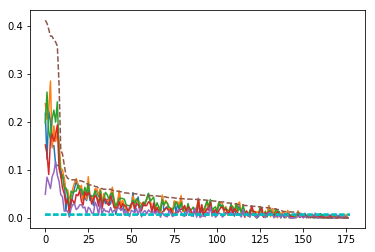

In [19]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in xrange(train.shape[2]-1 if np.any(lock) else train.shape[2]):
    plt.plot(score_condition[idx,k]/(DIM-1))
plt.plot(sigma_origin[idx] / (DIM-1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

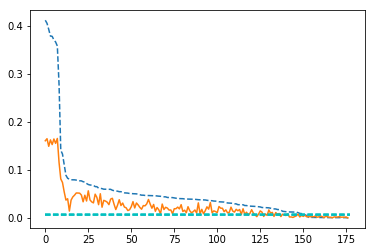

In [20]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM-1), '--')
plt.plot(np.sum(score_condition[idx, :] * weights[np.newaxis, :], axis=1) / (DIM-1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

## Vanilla Model Performance
#### Accuracy and Mutual Information Residue

In [21]:
# basic model with majority vote initialization
model_basic = MDPD.MDPD()
model_basic.fit(train, ncomp=EFF_NVOCAB, init='majority', verbose=False, epoch=50, lock=lock)
model_basic.accuracy(train, label)
model_basic.MI_residue(train)

2018-04-05 00:30:34,351 : INFO : Training an MDPD with dimension 177, 177 features, sample size 2653, vocab size 6 and the target number of components 4
2018-04-05 00:31:13,841 : INFO : ACCURACY: 83.00%
2018-04-05 00:31:17,263 : INFO : The mutual information residue (include all features) is 0.0155171677924
2018-04-05 00:31:17,268 : INFO : The mutual information residue (within selected features) is 0.0155171677924


In [27]:
log_post = model_basic.log_posterior(train)
score, weights = MDPD.utils.Feature_Selection.MI_score_conditional(train, log_post, rm_diag=True, lock=lock)
score_condition = score.sum(axis=1)
print 'Mutual Information Residue if use the true label as the posterior distribution'
print np.sum(score_condition * weights[np.newaxis, :]) / (DIM * (DIM - 1))

print 'Mutual Information Residue (within the selected features)'
score_select = score[features[:Ntop, np.newaxis], features[:Ntop], :]
res_select = np.sum(score_select.sum(axis=1) * weights[np.newaxis, :]) / (Ntop * (Ntop - 1))
print res_select

Mutual Information Residue if use the true label as the posterior distribution
0.0155171677924
Mutual Information Residue (within the selected features)
0.132562159079


#### [Plot] Mutual Information Residue vs the Residue of the Raw Data

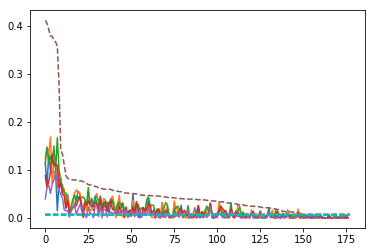

In [24]:
plt.figure()
idx = np.argsort(sigma_origin)[::-1]
for k in xrange(train.shape[2]-1 if np.any(lock) else train.shape[2]):
    plt.plot(score_condition[idx,k]/(DIM - 1))
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()

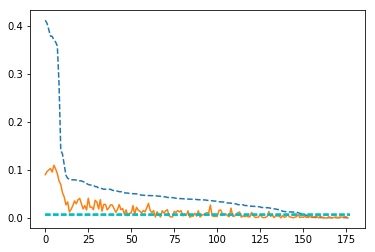

In [25]:
plt.figure()
plt.plot(sigma_origin[idx] / (DIM - 1), '--')
plt.plot(np.sum(score_condition[idx,:] * weights[np.newaxis, :], axis=1) / (DIM - 1))
# plot reference G statistics
for foo in percentiles[:3]:
    plt.plot([0, len(score)], [foo, foo], 'c--')
plt.show()